## Setup

In [37]:
# import all packages
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import os
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd 
import json 
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt

In [38]:
filepath = 'dataset/processed_data/train_valid_data/'
training = 'HC3_en_train.json'
validation = 'HC3_en_valid.json'

In [39]:
train_df = pd.read_json(filepath + training)
valid_df = pd.read_json(filepath + validation)

## Text Length Analysis

In [ ]:
def get_counts(df):
    data_size = len(df['text'])
    text = df['text']
    results = df['result']

    counts = {}
    human_counts = []
    llm_counts = []
    for i in range(data_size):
        count = len(text[i].split(' '))
        if results[i] == 0:
            human_counts.append(count)
        else:
            llm_counts.append(count)
        
        if count not in counts:
            counts[count] = {0: [], 1: []}
        counts[count][results[i]].append(text[i])

    return human_counts, llm_counts, counts

train_human, train_llm, train_counts = get_counts(train_df)
valid_human, valid_llm, valid_counts = get_counts(valid_df)

bins = [i * 100 for i in range(26)]

In [70]:
print(min(train_human[:80]))
print(max(train_human[:80]))
print(np.mean(train_human[:80]))

print(min(train_llm[:80]))
print(max(train_llm[:80]))
print(np.mean(train_llm[:80]))

7
524
118.0375
22
270
175.775


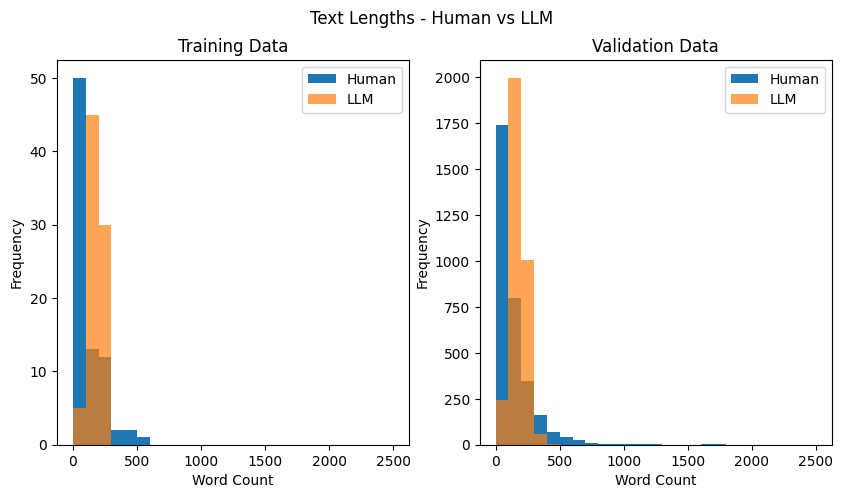

In [ ]:
# You can see the clear difference in distribution

plt.figure(figsize=(10, 5))
plt.suptitle('Text Lengths - Human vs LLM')

plt.subplot(1, 2, 1)
plt.title('Training Data')
plt.hist(train_human, bins, label='Human')
plt.hist(train_llm, bins, label='LLM', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Validation Data')
plt.hist(valid_human[:80], bins, label='Human')
plt.hist(valid_llm, bins, label='LLM', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

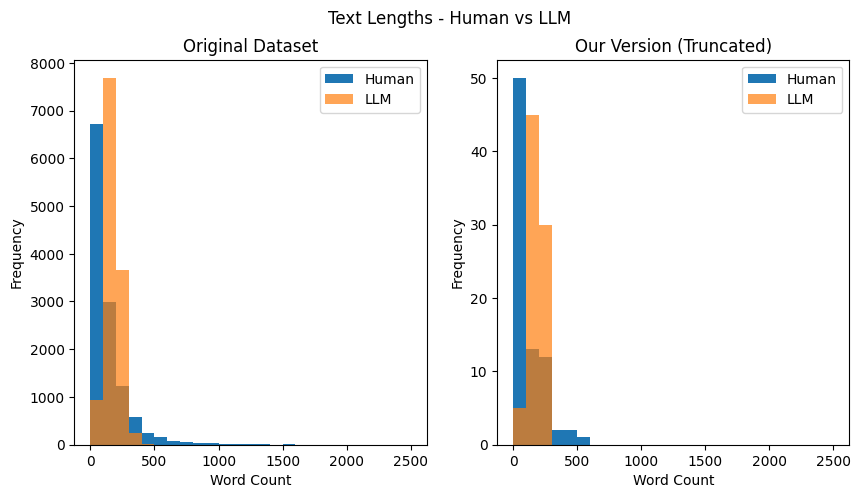

In [66]:
plt.figure(figsize=(10, 5))
plt.suptitle('Text Lengths - Human vs LLM')

plt.subplot(1, 2, 1)
plt.title('Original Dataset')
plt.hist(train_human, bins, label='Human')
plt.hist(train_llm, bins, label='LLM', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Our Version (Truncated)')
plt.hist(train_human[:80], bins, label='Human')
plt.hist(train_llm[:80], bins, label='LLM', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

## Preprocessing

In [42]:
def text_length_processing(counts):
    processed_data = []
    labels = []
    for count in counts:
        add = min(len(counts[count][0]), len(counts[count][1]))
        for a in range(add):
            processed_data.append({'text': counts[count][0][a], 'result': 0})
            processed_data.append({'text': counts[count][1][a], 'result': 1})
            labels.append(0)
            labels.append(1)

    return processed_data, labels

train_processed, train_labels = text_length_processing(train_counts)
valid_processed, valid_labels = text_length_processing(valid_counts)

In [ ]:
print(min(train_human[:80]))
print(max(train_human[:80]))

In [43]:
print(len(train_df))
print(len(valid_df))
print(len(train_processed))
print(len(valid_processed))

24701
6529
10686
2714


In [44]:
with open(f"{filepath}/HC3_en_train_textlength.json", "w") as f:
    json.dump(train_processed, f, indent=4)

with open(f"{filepath}/HC3_en_valid_textlength.json", "w") as f:
    json.dump(valid_processed, f, indent=4)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

torch.save(train_labels, "dataset/labels/HC3_en_train_textlength.pt")
torch.save(valid_labels, "dataset/labels/HC3_en_valid_textlength.pt")

## Model Results

In [61]:
# global variables
embedding_dim = 4096
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model
pretrained_model_name_or_path = '../huggingface_model/gte-Qwen1.5-7B-instruct'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path, trust_remote_code=True,device_map='auto' )
print(model.hf_device_map)

Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00, 110.79it/s]

{'': 'cpu'}


In [ ]:
def generate_embeddings(path, file_name, save_kl):
    
    def last_token_pool(last_hidden_states, attention_mask):
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[torch.arange(batch_size, device='cpu'), sequence_lengths]
    
    
    def get_kl_and_embeddings(input_texts, save_kl):
        # print('get_kl_and_embeddings being called')
        num_tokens = tokenizer(input_texts, return_tensors='pt', truncation=False, padding=False)['input_ids'].shape[1]

        max_length = 300
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**batch_dict,output_hidden_states=True)
            if save_kl: 
                # todo: used for test
                last_logits = model.lm_head(outputs.hidden_states[-1]).squeeze()
                first_logits = model.lm_head(outputs.hidden_states[0]).squeeze()
                
        
        all_embed = [last_token_pool(outputs.hidden_states[i].cpu(), batch_dict['attention_mask']) for i in range(len(outputs.hidden_states))]
        all_embed_concated = torch.concat(all_embed,1).cpu()

        if save_kl: 
            # # todo: used for test
            # last_logits = all_embed[-1]
            # # first_logits = all_embed[0]
            # first_logits = all_embed[1]
        
            kls = []
            for i in range(1,len(outputs.hidden_states)-1):
                with torch.no_grad():
                    middle_logits = model.lm_head(outputs.hidden_states[i]).squeeze()
                    # todo: used for test
                    # middle_logits = all_embed[i]
                kls.append(F.kl_div(F.log_softmax(middle_logits, dim=-1), F.softmax(first_logits, dim=-1), reduction='batchmean').item()+
                        F.kl_div(F.log_softmax(middle_logits, dim=-1), F.softmax(last_logits, dim=-1), reduction='batchmean').item())
            return kls, all_embed_concated
        
        return all_embed_concated


    with open(path, 'r') as f:
        data = json.load(f)
    if file_name == 'HC3_en_train_textlength':
        data = data[:200]
    elif file_name == 'HC3_en_valid_textlength':
        data = data[:40]

    kls = []
    embeddings = []
    for text_info in tqdm(data):
        text = text_info['text']
        result = text_info['result']
        prompt = text
        if save_kl: 
            kl, embedding = get_kl_and_embeddings([text], True)
            if kl is not None :
                kls.append(kl)
                embeddings.append(embedding)
        else :
            embedding = get_kl_and_embeddings([text], False)
            embeddings.append(embedding)
            if kl is not None :
                kls.append(kl)


    save_embed_dir = 'save/embeddings/'
    save_kl_dir = 'save/kl_divergence/all_tokens/' 
    # save kl divergence
    if save_kl:
        print(save_kl_dir+file_name+'.pkl')
        pickle.dump(kls, open(save_kl_dir+file_name+'.pkl', 'wb'))

    # save embeddings
    embeddings = torch.cat(embeddings, dim=0)
    print(save_embed_dir+file_name+'.pt')
    torch.save(embeddings, save_embed_dir+file_name+'.pt')

In [47]:
def get_embeddings_and_labels(file_name, data_path, device, layer_num):
    print("trying to get", file_name)
    # print(data_path)
    labels = torch.load(f'dataset/labels/' + file_name + '.pt').to(device)
    try:
        embeddings = torch.load(f'save/embeddings/' + file_name + '.pt')             
    except FileNotFoundError:
        # If saved embeddings not found, generate them
        print('target file not found, start generating embeddings')
        # print(data_path)
        generate_embeddings(data_path, file_name, layer_num == -1) #only compute and save kl is layer_num==-1, which means max-kl
        embeddings = torch.load(f'save/embeddings/' + file_name + '.pt') 
    
    if layer_num != -1:
        embeddings = embeddings[:,embedding_dim * layer_num: embedding_dim * (layer_num + 1)].to(device)
    else: #max_kl
        # with open(f'save/kl_divergence/last_token/' + file_name + '.pkl', 'rb') as f:
        with open(f'save/kl_divergence/all_tokens/' + file_name + '.pkl', 'rb') as f:
            kl = pickle.load(f)
            kl = np.array(kl)
            idx = kl.argmax(axis=1)
            embeddings = torch.tensor([row[(i+1)*embedding_dim:(i+2)*embedding_dim].tolist() for row ,i in zip(embeddings,idx) ]).to(device)

    return embeddings, labels
    

def get_train_eval_data(layer_num, device, train_num = 160, valid_num = 20) :
    train_embeddings, train_labels = get_embeddings_and_labels('HC3_en_train_textlength', 'dataset/processed_data/train_valid_data/HC3_en_train_textlength.json', device, layer_num)
    valid_embeddings, valid_labels = get_embeddings_and_labels('HC3_en_valid_textlength', 'dataset/processed_data/train_valid_data/HC3_en_valid_textlength.json', device, layer_num)
    return train_embeddings[:train_num], train_labels[:train_num], valid_embeddings[:valid_num], valid_labels[:valid_num]


In [48]:
# don't edit this cell
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[1024, 512], num_labels=2, dropout_prob=0.2):
        super(BinaryClassifier, self).__init__()
        self.num_labels = num_labels
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Dropout(dropout_prob),
                nn.Linear(prev_size, hidden_size),
                nn.Tanh(),
            ])
            prev_size = hidden_size
        self.dense = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_size, num_labels)
    
    def forward(self, x):
        x = self.dense(x)
        x = self.classifier(x)
        return x

In [49]:
def train(layer_num, device, hidden_sizes = [1024,512], droprate = 0.4, num_epochs = 10, learning_rate = 0.003):
    train_embeddings, train_labels, valid_embeddings, valid_labels = get_train_eval_data(layer_num, device)
    # print(train_embeddings.mean())
    print("the device being used is", device)
    print("there are", train_embeddings.shape[0], "train data and", valid_embeddings.shape[0], "validation data.")
    input_size = train_embeddings.shape[1]
    
    model = BinaryClassifier(input_size,hidden_sizes=hidden_sizes,dropout_prob=droprate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    batch_size = 16
    best_valid_acc = 0
    
    for epoch in range(num_epochs):
        for i in range(0, len(train_embeddings), batch_size):
            model.train()
            batch_embeddings = train_embeddings[i:i+batch_size].to(device)
            batch_labels = train_labels[i:i+batch_size].to(device)
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            outputs = model(valid_embeddings)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == valid_labels).sum().item() / len(valid_labels)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}")
            
    return model

In [50]:
def get_test_data(device, dataset_names, layer_num) :
    testset_embeddings, testset_labels, data_and_model_names = [], [], []
    for dataset_name in dataset_names: 
        for model_name in ['gpt3.5', 'gpt4', 'claude3']:
            test_embeddings, test_labels = get_embeddings_and_labels(dataset_name + '_' + model_name, 
                'dataset/processed_data/test_data/' + dataset_name + '_' + model_name + '.json', device, layer_num)
            testset_embeddings.append(test_embeddings)
            testset_labels.append(test_labels)
            data_and_model_names.append(dataset_name + "-" + model_name)
    return testset_embeddings, testset_labels, data_and_model_names

def group_and_average(name_to_auroc):
    grouped = defaultdict(list)
    for name, auroc in name_to_auroc.items():
        name_lower = name.lower()
        if 'gpt3' in name_lower or 'chatgpt' in name_lower:
            grouped['gpt3.5'].append(auroc)
        elif 'gpt4' in name_lower:
            grouped['gpt4'].append(auroc)
        elif 'claude' in name_lower:
            grouped['claude3'].append(auroc)
        else:
            print(f"Warning: could not classify {name}")
    
    avg_aurocs = {}
    for model_type in ['gpt3.5', 'gpt4', 'claude3']:
        if grouped[model_type]:
            avg_aurocs[model_type] = sum(grouped[model_type]) / len(grouped[model_type])
        else:
            avg_aurocs[model_type] = None
    
    return avg_aurocs


def run_single_test(model,test_set,test_label,test_acc,testset_name):
    with torch.no_grad():
        outputs = model(test_set)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        auroc = roc_auc_score(test_label.cpu().numpy(), probabilities.cpu().numpy())
        test_acc.append(auroc)
    return auroc

def run_all_tests(model, layer_num, device, dataset_names) :
    testset_embeddings, testset_labels, data_and_model_names = get_test_data(device, dataset_names, layer_num)
    with torch.no_grad():
        name_to_auroc = {}
        for test_embed, test_label, data_and_model_name in zip(testset_embeddings, testset_labels, data_and_model_names):
            auroc = run_single_test(model, test_embed, test_label, [], ' ')
            name_to_auroc[data_and_model_name] = auroc
    return name_to_auroc

In [51]:
def train_and_test_one_layer(layer_num, device, dataset_names = ['pub', 'writing', 'xsum']):
    model = train(layer_num, device)
    name_to_auroc = run_all_tests(model, layer_num, device, dataset_names)
    avg_aurocs = group_and_average(name_to_auroc)
    return avg_aurocs

In [52]:
if not os.path.exists('save'):
    os.mkdir('save')

if not os.path.exists('save/embeddings'):
    os.mkdir('save/embeddings')

if not os.path.exists('save/kl_divergence'):
    os.mkdir('save/kl_divergence')

if not os.path.exists('save/kl_divergence/all_tokens'):
    os.mkdir('save/kl_divergence/all_tokens')

In [53]:
train_and_test_one_layer(-1, device)

trying to get HC3_en_train_textlength
trying to get HC3_en_valid_textlength
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 1.4235, Validation Accuracy: 0.5000
Epoch [2/10], Loss: 0.7194, Validation Accuracy: 0.5000
Epoch [3/10], Loss: 0.5732, Validation Accuracy: 0.8500
Epoch [4/10], Loss: 0.4022, Validation Accuracy: 0.9500
Epoch [5/10], Loss: 0.1528, Validation Accuracy: 0.9500
Epoch [6/10], Loss: 0.0975, Validation Accuracy: 0.9500
Epoch [7/10], Loss: 0.1476, Validation Accuracy: 0.9500
Epoch [8/10], Loss: 0.0273, Validation Accuracy: 1.0000
Epoch [9/10], Loss: 0.0349, Validation Accuracy: 0.9500
Epoch [10/10], Loss: 0.1097, Validation Accuracy: 1.0000
trying to get pub_gpt3.5
trying to get pub_gpt4
trying to get pub_claude3
trying to get writing_gpt3.5
trying to get writing_gpt4
trying to get writing_claude3
trying to get xsum_gpt3.5
trying to get xsum_gpt4
trying to get xsum_claude3


{'gpt3.5': 0.9178074074074075, 'gpt4': 0.9208064908654432, 'claude3': 0.9682718065003778}

In [54]:
with open('save/kl_divergence/all_tokens/HC3_en_train_textlength.pkl', 'rb') as f:
  textlength_train = pickle.load(f)

with open('save/kl_divergence/all_tokens/HC3_en_valid_textlength.pkl', 'rb') as f:
  textlength_valid = pickle.load(f)

with open('save/kl_divergence/all_tokens/HC3_en_valid_textlength.pkl', 'rb') as f:
  textlength_valid = pickle.load(f)

kl = np.array(textlength_train)
idx = kl.argmax(axis=1)
print(idx)

kl = np.array(textlength_valid)
idx = kl.argmax(axis=1)
print(idx)

[29 30 30 30 30 29 30 30 30 30 30 30 30 29 30 30 30 30 29 30 30 29 30 29
 30 29 30 30 30 29 30 30 30 30 30 30 30 29 30 29 30 30 30 29 29 30 30 30
 30 29 30 30 29 29 30 30 30 30 29 30 30 30 29 30 30 30 30 30 30 30 30 29
 30 30 30 30 29 30 30 30 29 30 29 30 30 30 30 30 30 30 30 30 30 30 29 30
 29 30 30 30 30 30 30 30 30 30 29 30 30 30 29 29 30 30 30 30 29 29 29 29
 29 30 30 30 30 30 30 30 30 30 30 29 30 29 29 29 29 29 30 29 30 29 30 30
 29 30 30 29 30 29 29 30 30 29 29 30 29 30 30 30 29 30 29 30 30 30 30 30
 29 29 30 30 30 30 30 29 30 29 30 29 30 29 29 29 30 30 30 30 29 30 29 30
 30 30 30 30 30 29 30 30]
[30 29 29 30 30 29 30 30 30 30 30 30 30 30 29 30 30 30 30 29 29 30 30 30
 30 30 29 30 30 30 29 29 30 30 30 30 29 30 30 30]


In [55]:
# first layer
avg_aurocs = train_and_test_one_layer(0, device)
print(avg_aurocs)

# last layer
avg_aurocs = train_and_test_one_layer(32, device)
print(avg_aurocs)

trying to get HC3_en_train_textlength
trying to get HC3_en_valid_textlength
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.6914, Validation Accuracy: 0.5000
Epoch [2/10], Loss: 0.7162, Validation Accuracy: 0.5000
Epoch [3/10], Loss: 0.7144, Validation Accuracy: 0.5000
Epoch [4/10], Loss: 0.7144, Validation Accuracy: 0.5000
Epoch [5/10], Loss: 0.7480, Validation Accuracy: 0.5000
Epoch [6/10], Loss: 0.7068, Validation Accuracy: 0.5000
Epoch [7/10], Loss: 0.6910, Validation Accuracy: 0.5000
Epoch [8/10], Loss: 0.6743, Validation Accuracy: 0.5000
Epoch [9/10], Loss: 0.6371, Validation Accuracy: 0.5000
Epoch [10/10], Loss: 0.7025, Validation Accuracy: 0.5000
trying to get pub_gpt3.5
trying to get pub_gpt4
trying to get pub_claude3
trying to get writing_gpt3.5
trying to get writing_gpt4
trying to get writing_claude3
trying to get xsum_gpt3.5
trying to get xsum_gpt4
trying to get xsum_claude3
{'gpt3.5': 0.5, 'gpt4': 0.5, 'claude3': 0.5}
tr

layer_num = 0
trying to get HC3_en_train_textlength
trying to get HC3_en_valid_textlength
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.7633, Validation Accuracy: 0.5000
Epoch [2/10], Loss: 0.6954, Validation Accuracy: 0.5000
Epoch [3/10], Loss: 0.6903, Validation Accuracy: 0.5000
Epoch [4/10], Loss: 0.7188, Validation Accuracy: 0.5000
Epoch [5/10], Loss: 0.6855, Validation Accuracy: 0.5000
Epoch [6/10], Loss: 0.6499, Validation Accuracy: 0.5000
Epoch [7/10], Loss: 0.6266, Validation Accuracy: 0.5000
Epoch [8/10], Loss: 0.8175, Validation Accuracy: 0.5000
Epoch [9/10], Loss: 0.6942, Validation Accuracy: 0.5000
Epoch [10/10], Loss: 0.7009, Validation Accuracy: 0.5000
trying to get pub_gpt3.5
trying to get pub_gpt4
trying to get pub_claude3
trying to get writing_gpt3.5
trying to get writing_gpt4
trying to get writing_claude3
trying to get xsum_gpt3.5
trying to get xsum_gpt4
trying to get xsum_claude3
layer_num = 1
trying to get HC3_e

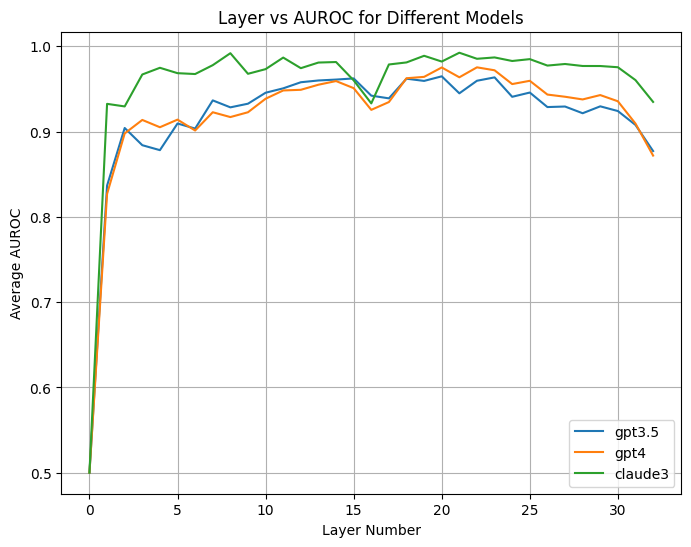

In [56]:
layer_to_aurocs = {'gpt3.5': [], 'gpt4': [], 'claude3': []}
layer_nums = []

for layer_num in range(33):
    print("layer_num =", layer_num)
    layer_nums.append(layer_num)
    avg_aurocs = train_and_test_one_layer(layer_num, device)
    for model_type in ['gpt3.5', 'gpt4', 'claude3']:
        layer_to_aurocs[model_type].append(avg_aurocs[model_type])


# plot (similar to Figure 2 in their paper)
plt.figure(figsize=(8, 6))
for model_type, aucs in layer_to_aurocs.items():
    plt.plot(layer_nums, aucs, label=model_type)

plt.xlabel('Layer Number')
plt.ylabel('Average AUROC')
plt.title('Layer vs AUROC for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
from pprint import pprint

for model_type in layer_to_aurocs:
    print(model_type)
    print(layer_to_aurocs[model_type][20:26])


gpt3.5
[0.9647407407407407, 0.9448, 0.9595407407407407, 0.9634962962962964, 0.9407259259259261, 0.9457185185185185]
gpt4
[0.9751112138759183, 0.9635948664307747, 0.9752655465970003, 0.971808756695978, 0.9556489374018854, 0.9594836795806662]
claude3
[0.982043537414966, 0.9924027966742252, 0.9852961451247165, 0.9868799697656842, 0.9827120181405894, 0.9848870748299321]


In [59]:
# # first layer
# avg_aurocs = train_and_test_one_layer(0, device)
# print(avg_aurocs)

# last layer
avg_aurocs = train_and_test_one_layer(33, device, ['pub'])
print(avg_aurocs)

trying to get HC3_en_train_textlength
trying to get HC3_en_valid_textlength
the device being used is cuda
there are 160 train data and 20 validation data.
Epoch [1/10], Loss: 0.6935, Validation Accuracy: 0.5000
Epoch [2/10], Loss: 0.6888, Validation Accuracy: 0.5000


/homes/iws/chahn317/.local/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch [3/10], Loss: 0.6957, Validation Accuracy: 0.5000
Epoch [4/10], Loss: 0.6885, Validation Accuracy: 0.5000
Epoch [5/10], Loss: 0.6831, Validation Accuracy: 0.5000
Epoch [6/10], Loss: 0.7146, Validation Accuracy: 0.5000
Epoch [7/10], Loss: 0.7204, Validation Accuracy: 0.5000
Epoch [8/10], Loss: 0.6903, Validation Accuracy: 0.5000
Epoch [9/10], Loss: 0.7039, Validation Accuracy: 0.5000
Epoch [10/10], Loss: 0.6913, Validation Accuracy: 0.5000
trying to get pub_gpt3.5
trying to get pub_gpt4
trying to get pub_claude3
{'gpt3.5': 0.5, 'gpt4': 0.5, 'claude3': 0.5}
